In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from matplotlib import pyplot as plt

import os
import numpy as np
from pytorch_metric_learning import losses

In [53]:
from models import densenet161, mobilenet_v2, make_model, vgg16
from dataset import make_dataloaders, get_crop_to_opposite_original_df
from losses import ContrastiveLoss
from train import do_train
from infer_utils import (
    predict_opposite_crop_to_crop,
    predict_original_to_crop,
    predict_opposite_original_to_crop,
    plot_match_pairs,
)
from utils import compute_accuracy, plot_train_results, make_dir

In [4]:
ds_path = '/home/korakova/kaggle/'

Попробуем дообучить модели, которые отобрали на шаге 1 с помощью Contrastive Loss

### Train vgg16/densenet161 with ContrastiveLoss

### 1. Crop to opposite crop match

In [49]:
num_epochs = 20
num_workers = 10
batch_size = 20
lr = 1e-4
train_last_layers = False
pretrained = True
step_size = 200
gamma = 0.8
margin = 2

model_type = vgg16
model_name = "vgg16"
task_type = "crop_crop"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
exp_name = (
    f"{task_type}_{model_name}_{lr}_ss_{step_size}_ll_{train_last_layers}_m_{margin}"
)
weight_directory = os.path.join("results", exp_name)
make_dir(weight_directory)
dataloaders = make_dataloaders(task_type, batch_size, num_workers)

In [50]:
model, params_to_update = make_model(
    train_last_layers, pretrained, device, model_type
)
criterion = ContrastiveLoss(margin)
optimizer = optim.Adam(params_to_update, lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [51]:
train_result = do_train(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs,
    weight_directory,
)

100%|██████████| 20/20 [02:08<00:00,  6.45s/it, epoch=19, loss=tensor(0.0202), lr=0.0001]


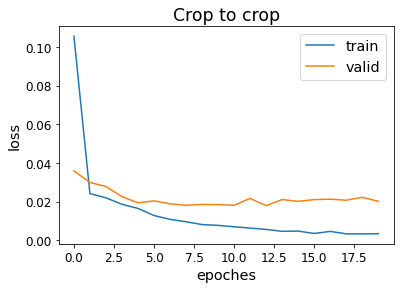

In [54]:
plot_train_results(train_result, 'Crop to crop')

#### Compute quality on validation set

In [13]:
target_df = get_crop_to_opposite_original_df()

In [15]:
model_weight = 'best_model.pt'
features = "local"
weights = f"results/{exp_name}/{model_weight}"

batch_size=1
model_type = vgg16
task_type = 'crop_crop'

dataloaders = make_dataloaders(task_type, batch_size)
model, _ = make_model(False, False, "cpu", model_type, weights)

pred_crop_crop = predict_opposite_crop_to_crop(model, features, dataloaders["test"], target_df)

100%|██████████| 25/25 [00:06<00:00,  4.05it/s]


In [18]:
accuracy = compute_accuracy(pred_crop_crop, "path_crop_opposite", "path_crop_opposite_gt")
print(f'Accuracy for crop to crop match {accuracy}')

Accuracy for crop to crop match 0.8


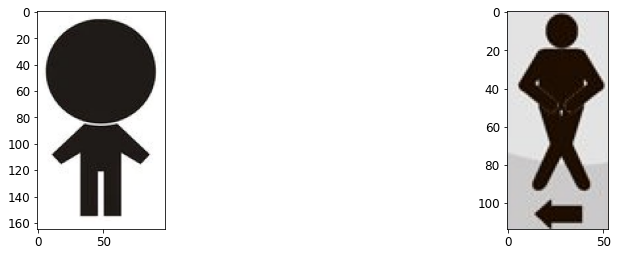

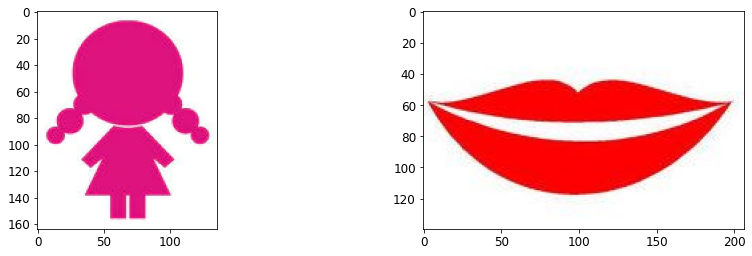

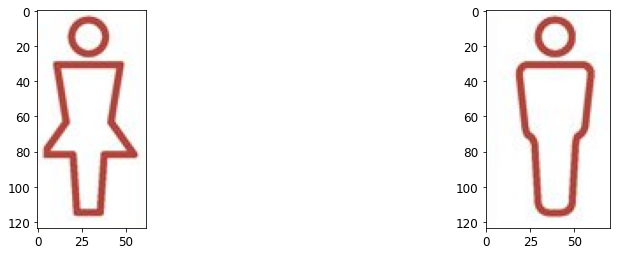

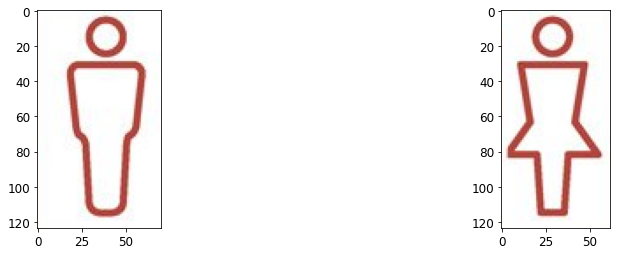

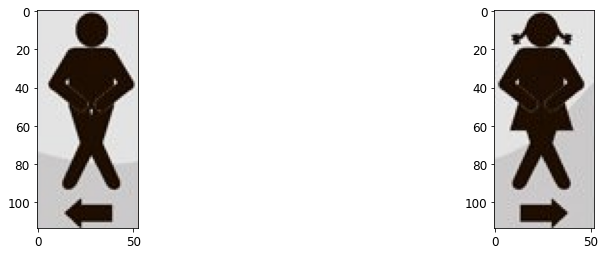

In [19]:
plot_match_pairs(pred_crop_crop, 5, 'path_crop_opposite')

### 2. Crop to original same gender

In [24]:
num_epochs = 20
num_workers = 10
batch_size = 20
lr = 1e-5
train_last_layers = False
pretrained = True
step_size = 200
gamma = 0.8
margin = 2

model_type = densenet161
model_name = "densenet161"
task_type = "crop_orig"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
exp_name = (
    f"{task_type}_{model_name}_{lr}_ss_{step_size}_ll_{train_last_layers}_m_{margin}"
)
weight_directory = os.path.join("results", exp_name)
if not os.path.exists(weight_directory):
    os.system(f"mkdir {weight_directory}")
dataloaders = make_dataloaders(task_type, batch_size, num_workers)

In [25]:
model, params_to_update = make_model(
    train_last_layers, pretrained, device, model_type
)
criterion = ContrastiveLoss(margin)
optimizer = optim.Adam(params_to_update, lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [26]:
train_result = do_train(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs,
    weight_directory,
)

100%|██████████| 20/20 [04:00<00:00, 12.01s/it, epoch=19, loss=tensor(0.0328), lr=8e-6]


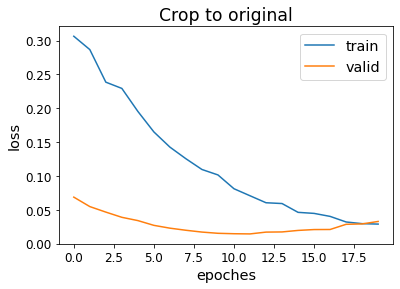

In [47]:
plot_train_results(train_result, 'Crop to original')

#### Compute quality on validation set

In [28]:
model_weight = 'best_model.pt'
features = "local"
weights = f"results/{exp_name}/{model_weight}"

batch_size=1
model_type = densenet161
task_type = "crop_orig"

model, _ = make_model(False, False, "cpu", model_type, weights)
dataloaders = make_dataloaders(task_type, batch_size, num_workers)

pred_crop_orig = predict_original_to_crop(model, features, dataloaders["test"], target_df)

100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


In [42]:
accuracy = compute_accuracy(pred_crop_orig, "path_orig", "path_orig_gt")
print(f'Accuracy for crop to original match {accuracy}')

Accuracy for crop to original match 0.7


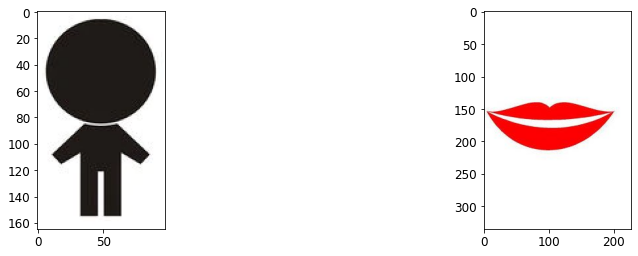

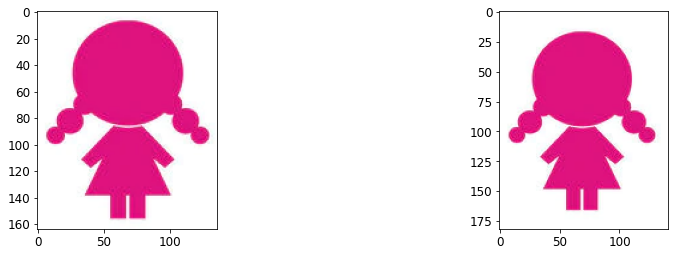

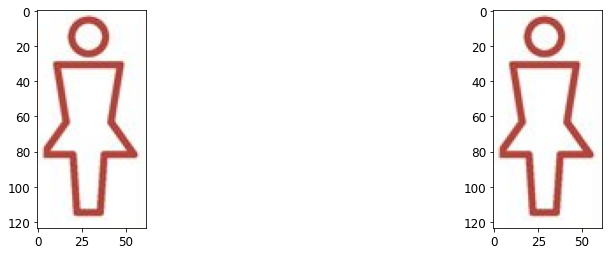

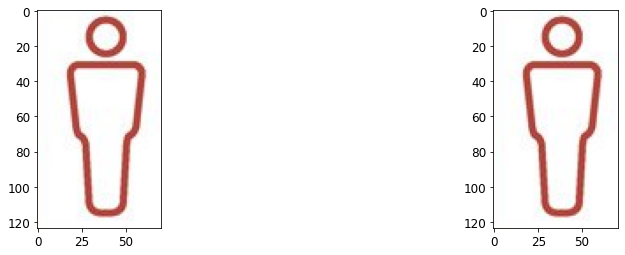

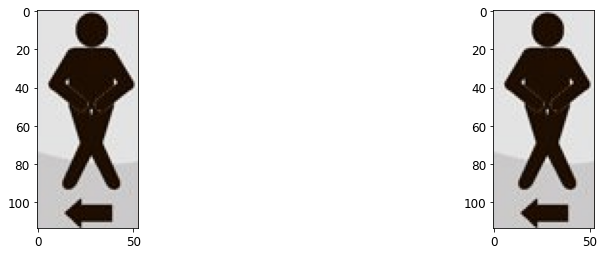

In [31]:
plot_match_pairs(pred_crop_orig, 5, 'path_orig')

#### 3. Crop to original opposite match

In [32]:
df_result = predict_opposite_original_to_crop(pred_crop_crop, pred_crop_orig, target_df)

In [33]:
accuracy = compute_accuracy(df_result, "path_orig", "path_orig_opposite")
print(f'Accuracy for crop to original opposite match {accuracy}')

Accuracy for crop to original opposite match 0.56


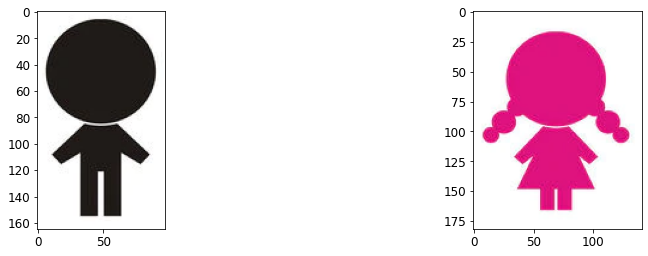

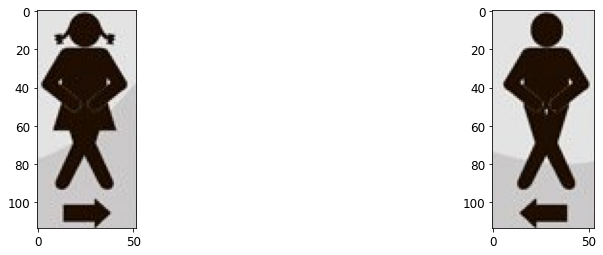

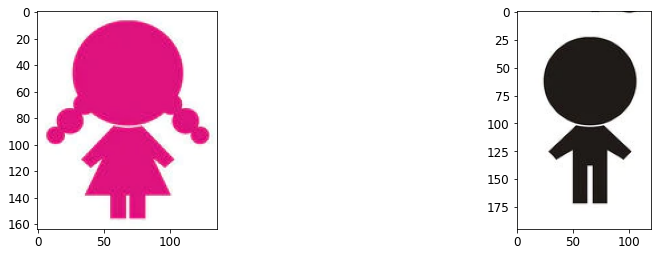

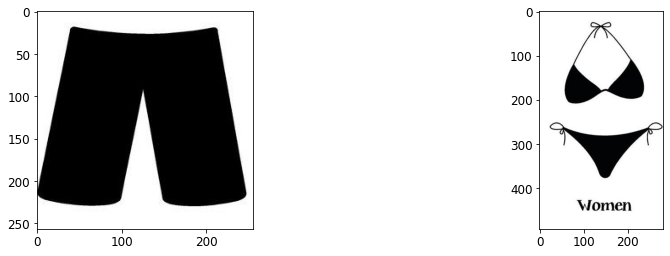

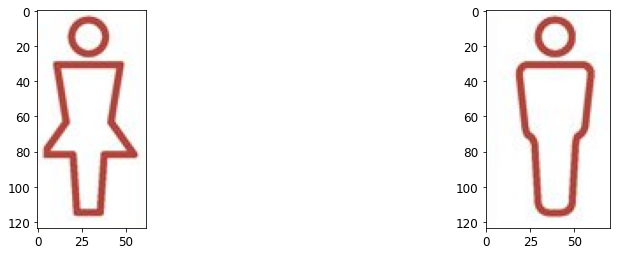

In [36]:
plot_match_pairs(df_result, 5, "path_orig_opposite")